# Predicting US Domestic Avocado Prices

Our goal is to build at least three models to predict the average US domestic Avocado price based on <a href="https://www.kaggle.com/neuromusic/avocado-prices/home">historical data available on Kaggle</a> originating from the <a href="http://www.hassavocadoboard.com/retail/volume-and-price-data">Haas Avocado Board</a>. 

The resulting models will be stacked in order to demonstrate the power of ensemble models in a subsequent notebook. 

## Description of the dataset

The data represent weekly retail scan data for National retail volume (units) and price for an approximately 3-year period beginning in January 2015. Retail scan data comes directly from retailers’ cash registers based on actual retail sales of Hass avocados. 

The Average Price (of avocados) in the table reflects a per unit (per avocado) cost, even when multiple units (avocados) are sold in bags. The Product Lookup codes (PLU’s) in the table are only for Hass avocados. Other varieties of avocados (e.g. greenskins) are not included in this table.

Some relevant columns in the dataset:

<ul>
<li>Date - The date of the observation
<li>AveragePrice - the average price of a single avocado
<li>type - conventional or organic
<li>year - the year
<li>Region - the city or region of the observation
<li>Total Volume - Total number of avocados sold
<li>4046 - Total number of avocados with PLU 4046 sold
<li>4225 - Total number of avocados with PLU 4225 sold
<li>4770 - Total number of avocados with PLU 4770 sold
</ul>

In [229]:
## Library imports
import math
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit

import xgboost as xgb
from xgboost.sklearn import XGBRegressor

from fbprophet import Prophet

%matplotlib inline

## Data Exploration and Cleaning

In [2]:
data = pd.read_csv("avocado.csv")
data.head()

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [3]:
data = data.drop(['Unnamed: 0'], axis = 1)
data.rename(columns={"4046": "SmHassQty", "4225": "LgHassQty", "4770": "ExLgHassQty"}, inplace=True)
data.head()

,Date,AveragePrice,Total Volume,SmHassQty,LgHassQty,ExLgHassQty,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [4]:
# Let's get a sense of what's here
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18249 entries, 0 to 18248
Data columns (total 13 columns):
Date            18249 non-null object
AveragePrice    18249 non-null float64
Total Volume    18249 non-null float64
SmHassQty       18249 non-null float64
LgHassQty       18249 non-null float64
ExLgHassQty     18249 non-null float64
Total Bags      18249 non-null float64
Small Bags      18249 non-null float64
Large Bags      18249 non-null float64
XLarge Bags     18249 non-null float64
type            18249 non-null object
year            18249 non-null int64
region          18249 non-null object
dtypes: float64(9), int64(1), object(3)
memory usage: 1.8+ MB


In [24]:
data.describe()

,AveragePrice,Total Volume,SmHassQty,LgHassQty,ExLgHassQty,Total Bags,Small Bags,Large Bags,XLarge Bags,year
count,18249.000000,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,18249.000000,18249.000000
mean,1.405978,8.506440e+05,2.930084e+05,2.951546e+05,2.283974e+04,2.396392e+05,1.821947e+05,5.433809e+04,3106.426507,2016.147899
std,0.402677,3.453545e+06,1.264989e+06,1.204120e+06,1.074641e+05,9.862424e+05,7.461785e+05,2.439660e+05,17692.894652,0.939938
min,0.440000,8.456000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,2015.000000
25%,1.100000,1.083858e+04,8.540700e+02,3.008780e+03,0.000000e+00,5.088640e+03,2.849420e+03,1.274700e+02,0.000000,2015.000000
50%,1.370000,1.073768e+05,8.645300e+03,2.906102e+04,1.849900e+02,3.974383e+04,2.636282e+04,2.647710e+03,0.000000,2016.000000
75%,1.660000,4.329623e+05,1.110202e+05,1.502069e+05,6.243420e+03,1.107834e+05,8.333767e+04,2.202925e+04,132.500000,2017.000000
max,3.250000,6.250565e+07,2.274362e+07,2.047057e+07,2.546439e+06,1.937313e+07,1.338459e+07,5.719097e+06,551693.650000,2018.000000


In [6]:
print(f"There are pricing data for {len(data['region'].value_counts())} regions and {len(data['Date'].value_counts())} dates represented in the dataset.")

There are pricing data for 54 regions and 169 dates represented in the dataset.


In [7]:
# Checking which regions are represented, we see that the WestTexNewMexico region has 3 fewer entries than the other regions. 
# We also see that (for most of the regions) there are 2 * 169 = 338 entries. This is because for each date and each region, we have two prices: one for conventional and another for organic avocados

data['region'].value_counts()

Nashville              338
SouthCentral           338
BuffaloRochester       338
Midsouth               338
MiamiFtLauderdale      338
Seattle                338
Syracuse               338
LasVegas               338
NewYork                338
PhoenixTucson          338
TotalUS                338
CincinnatiDayton       338
Boise                  338
Jacksonville           338
Albany                 338
Indianapolis           338
Southeast              338
West                   338
NewOrleansMobile       338
SouthCarolina          338
Louisville             338
Houston                338
Chicago                338
StLouis                338
Spokane                338
Roanoke                338
GrandRapids            338
Denver                 338
Sacramento             338
Columbus               338
NorthernNewEngland     338
RichmondNorfolk        338
HartfordSpringfield    338
Orlando                338
RaleighGreensboro      338
Charlotte              338
SanDiego               338
B

In [44]:
# Let's look at WestTexNewMexico in more detail
wtnm = data.loc[data['region'] == 'WestTexNewMexico' ].groupby('Date').agg('count')
wtnm

,AveragePrice,Total Volume,SmHassQty,LgHassQty,ExLgHassQty,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
Date,,,,,,,,,,,,
2015-01-04,2,2,2,2,2,2,2,2,2,2,2,2
2015-01-11,2,2,2,2,2,2,2,2,2,2,2,2
2015-01-18,2,2,2,2,2,2,2,2,2,2,2,2
2015-01-25,2,2,2,2,2,2,2,2,2,2,2,2
2015-02-01,2,2,2,2,2,2,2,2,2,2,2,2
2015-02-08,2,2,2,2,2,2,2,2,2,2,2,2
2015-02-15,2,2,2,2,2,2,2,2,2,2,2,2
2015-02-22,2,2,2,2,2,2,2,2,2,2,2,2
2015-03-01,2,2,2,2,2,2,2,2,2,2,2,2


In [42]:
wtnm.loc[ wtnm['AveragePrice'] != 2 ]

,AveragePrice,Total Volume,SmHassQty,LgHassQty,ExLgHassQty,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
Date,,,,,,,,,,,,
2015-12-06,1,1,1,1,1,1,1,1,1,1,1,1
2017-06-18,1,1,1,1,1,1,1,1,1,1,1,1
2017-06-25,1,1,1,1,1,1,1,1,1,1,1,1


In [65]:
# Here we see that we are missing the price for 'organic' type avocados on one of these days. 
# Closer examination shows that this is the problem with all three of the dates above
data.loc[ data['Date']=='2015-12-06' ][data['region']=='WestTexNewMexico']


/Users/david/anaconda2/envs/PythonData/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


,Date,AveragePrice,Total Volume,SmHassQty,LgHassQty,ExLgHassQty,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
2759,2015-12-06,0.74,623231.77,398871.12,133434.18,21088.12,69838.35,68233.56,1604.79,0.0,conventional,2015,WestTexNewMexico


In [79]:
# The least destructive means of compensating for the missing data would be to insert the three missing rows with estimated values for the missing data. 
# However, in the interest of time, we will take the brutish approach of simply dropping the WestTexNewMexico region from the dataset. 
# Will it matter if we do that?
nm_share = data.groupby('region').agg('sum')['Total Volume']['WestTexNewMexico'] / data['Total Volume'].sum()
nm_share = round(100*nm_share, 2)
print(f"The WestTexNewMexico region accounts for {nm_share}% of the total volume.")


The WestTexNewMexico region accounts for 0.93% of the total volume.


In [96]:
# No, it won't. 
data_cleaned = data.loc[ data['region'].str.contains('WestTexNewMexico') == False ].copy()

In [97]:
data_cleaned['region'].value_counts()

Nashville              338
GrandRapids            338
BuffaloRochester       338
Midsouth               338
MiamiFtLauderdale      338
Seattle                338
Syracuse               338
LasVegas               338
NewYork                338
PhoenixTucson          338
TotalUS                338
CincinnatiDayton       338
Boise                  338
Jacksonville           338
Albany                 338
Indianapolis           338
Southeast              338
West                   338
NewOrleansMobile       338
SouthCarolina          338
Louisville             338
Houston                338
Chicago                338
StLouis                338
Spokane                338
Roanoke                338
Denver                 338
SouthCentral           338
Atlanta                338
Columbus               338
NorthernNewEngland     338
RichmondNorfolk        338
HartfordSpringfield    338
Orlando                338
RaleighGreensboro      338
Charlotte              338
SanDiego               338
B

In [98]:
assert [n for n in data_cleaned["region"].value_counts() if n != 338] == []

In [99]:
assert [ d for d in data_cleaned["Date"].value_counts() if d != 106 ] == [] 

In [100]:
data = data_cleaned

In [115]:
## We can now see that we have 169 weeks of data for our two types of avocado across 53 different regions. 
17914/169/2
date_counts = data.groupby(['region', 'type']).agg('count')['Date']
try:
    assert [ n for n in date_counts if n != 169 ] == [ ]
except AssertionError:
    print("Assertion failed!")
date_counts

region               type        
Albany               conventional    169
                     organic         169
Atlanta              conventional    169
                     organic         169
BaltimoreWashington  conventional    169
                     organic         169
Boise                conventional    169
                     organic         169
Boston               conventional    169
                     organic         169
BuffaloRochester     conventional    169
                     organic         169
California           conventional    169
                     organic         169
Charlotte            conventional    169
                     organic         169
Chicago              conventional    169
                     organic         169
CincinnatiDayton     conventional    169
                     organic         169
Columbus             conventional    169
                     organic         169
DallasFtWorth        conventional    169
                     or

## Feature Engineering

We will want to contruct features that will alow our models to find any periodic variations that are present in the data. Our data has granularity of a week. Since annual periodicity is expected, we should therefore encode the week of the year.  

A little research into the avocado industry suggests that Cinco de Mayo might be an important date affecting avocado sales in some regions. Since Cinco de Mayo always occurs in the same week of the year, we don't really have to add a lagged feature for it, unless we want to assess its importance in the model. It's not hard, though, so let's go ahead and do it. 

We'll do more exploration of periodicities that may be present later, but let's start with these features for now. 

### Time

In [116]:
data = data.assign( Date=pd.to_datetime(data.Date) )

In [117]:
# month of the year
data = data.assign( month=[x.month for x in data.Date])

In [118]:
# week of the year
data = data.assign( week=[x.isocalendar()[1] for x in data.Date])

In [119]:
# Weeks until 'Cinco dey Mayo'
data = data.assign( weeks_before_cdm=[ dt.datetime(r['year'], 5, 5).isocalendar()[1] - r['week'] for i, r in data.iterrows() ] )

In [120]:
# Let's sort the data in preparation for splitting into training and test samples
data = data.sort_values(['year', 'month', 'week', 'region', 'type'], ascending=[True, True, True, True, True])

In [121]:
data = data.reset_index(drop=True)

In [122]:
data.head()

,Date,AveragePrice,Total Volume,SmHassQty,LgHassQty,ExLgHassQty,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,month,week,weeks_before_cdm
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany,1,1,18
1,2015-01-04,1.79,1373.95,57.42,153.88,0.00,1162.65,1162.65,0.00,0.0,organic,2015,Albany,1,1,18
2,2015-01-04,1.00,435021.49,364302.39,23821.16,82.15,46815.79,16707.15,30108.64,0.0,conventional,2015,Atlanta,1,1,18
3,2015-01-04,1.76,3846.69,1500.15,938.35,0.00,1408.19,1071.35,336.84,0.0,organic,2015,Atlanta,1,1,18
4,2015-01-04,1.08,788025.06,53987.31,552906.04,39995.03,141136.68,137146.07,3990.61,0.0,conventional,2015,BaltimoreWashington,1,1,18


## Row-consolidated Data

Our dataset may have over 18,000 rows, but it really just a time series at 169 distinct times. For training our models (and splitting the data into training vs. testing samples) it is more useful to think of the data set this way. 

For each time, we have 7 quantities that are specific to each of the 53 regions. Adding in our time-lag features (of which there are four), we end up with a time series of 169 data points where each point is a vector with 53 * 7 + 4 = 375 components. 

We could consider our Y-variable to have seven components: namely, the Total Volume, SmHassQty, LgHassQty, TotalBags, SmallBags, LargeBags and AveragePrice corresponding to the region "TotalUS." From this point of view we have a dataset with 52 7-dimensional non-temporal X-features. However, we are only really concerned with predicting the scalar, AveragePrice, for the TotalUS region. If we were to consider all of our features as scalars, we would have more features than we have data points, and any models we attempt to fit by utilizing all of the features will be underconstrained. We have too much complexity. 

Let us therefore reduce the complexity by utilizing only the AveragePrice by region as the set of scalar features in our X-variable. 

In [296]:
regions = data.region.unique()

array(['Albany', 'Atlanta', 'BaltimoreWashington', 'Boise', 'Boston',
       'BuffaloRochester', 'California', 'Charlotte', 'Chicago',
       'CincinnatiDayton', 'Columbus', 'DallasFtWorth', 'Denver',
       'Detroit', 'GrandRapids', 'GreatLakes', 'HarrisburgScranton',
       'HartfordSpringfield', 'Houston', 'Indianapolis', 'Jacksonville',
       'LasVegas', 'LosAngeles', 'Louisville', 'MiamiFtLauderdale',
       'Midsouth', 'Nashville', 'NewOrleansMobile', 'NewYork', 'Northeast',
       'NorthernNewEngland', 'Orlando', 'Philadelphia', 'PhoenixTucson',
       'Pittsburgh', 'Plains', 'Portland', 'RaleighGreensboro',
       'RichmondNorfolk', 'Roanoke', 'Sacramento', 'SanDiego',
       'SanFrancisco', 'Seattle', 'SouthCarolina', 'SouthCentral',
       'Southeast', 'Spokane', 'StLouis', 'Syracuse', 'Tampa', 'TotalUS',
       'West'], dtype=object)

In [361]:
#sales_features_num = ['Total Volume', 'SmHassQty', 'LgHassQty', 'Total Bags', 'Small Bags', 'Large Bags', 'AveragePrice']
sales_features_num = ['AveragePrice']

In [362]:

regionalSalesInfo = [ data.loc[ (data['type']=='conventional') & (data['region']==r) ][[ f for f in sales_features_num ]] for r in regions ]

In [363]:
refactored_data = { r + sfn : list(regionalSalesInfo[i][sfn].values) for sfn in sales_features_num for i, r in enumerate(regions) }

In [365]:
region_consolidated_df = pd.DataFrame( refactored_data )

In [366]:
region_consolidated_df = region_consolidated_df.assign( Date=data.Date, year=data.year, month=data.month, week=data.week, weeks_before_cdm=data.weeks_before_cdm )

### Categorical variables

In [367]:
## Convert categorical variables to dummy columns 
# data_with_categorical= pd.get_dummies(data)

In [368]:
# data_with_categorical.keys()

## Training & Validation subset selection [depricated]

Since this is a time-series and we are interested in predicting the average future price without knowledge any future regional prices, we will want to take special care that we divide our data set cleanly to keep all observations for a given date together. 

<b>NOTE:</b> This section is no longer needed since we have refactored our data, grouping our X-variable by Date

In [126]:
# The best number of cross-validation trials to do can be revisited if we have time.
# For now we choose 5. 
tscv = TimeSeriesSplit(n_splits=5)

In [127]:
# This holds all the indicies of the rows grouped by Date
time_series_groups = np.array(list(data.groupby('Date').groups.values()))

In [128]:
train_trial_index = []
test_trial_index = []
# Each itertion of this loop defines the data subsets to be used in 
# one our five cross-validation trials
for train_tsi, test_tsi in tscv.split(time_series_groups):
    this_train = []
    this_test = []
    for x in train_tsi:
        for i in time_series_groups[x]:
            this_train.append(i)
    for x in test_tsi:
        for i in time_series_groups[x]:
            this_test.append(i)
    test_trial_index.append(this_test)
    train_trial_index.append(this_train)

In [277]:
# We need to do the above as a generator to give as input to the cross-validation framework
def split_ts_group_samples(n_splits, time_series_groups):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    for train_tsi, test_tsi in tscv.split(time_series_groups):
        this_train = []
        this_test = []
        for x in train_tsi:
            for i in time_series_groups[x]:
                this_train.append(i)
        for x in test_tsi:
            for i in time_series_groups[x]:
                this_test.append(i)
        yield this_train, this_test

## X, Y Data preparation

In [416]:
target = "TotalUSAveragePrice"

In [398]:
# X_price_cols = [ c for c in region_consolidated_df.columns.values if ('AveragePrice' in c) & ('TotalUS' not in c) ]

In [408]:
X_time_cols = ['year', 'month', 'week', 'weeks_before_cdm']

In [417]:
# Create dataframes containing the X and Y numerical data only
# X_features = X_price_cols + X_time_cols
X_features = X_time_cols

In [418]:
X = region_consolidated_df[X_features].values
Y = region_consolidated_df[target].values.ravel()

# Models

## Random Forest Regressor with Regional Average Prices

In [419]:
clf_rfn = make_pipeline(StandardScaler(), RandomForestRegressor(random_state=1, n_estimators=150))

In [420]:
cv = TimeSeriesSplit(n_splits=5)

In [421]:
scores = cross_val_score(clf_rfn, X, Y, cv=cv, n_jobs=-1 )

/Users/david/anaconda2/envs/PythonData/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
/Users/david/anaconda2/envs/PythonData/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
/Users/david/anaconda2/envs/PythonData/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
/Users/david/anaconda2/envs/PythonData/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
/Users/david/anaconda2/envs/PythonData/l

In [423]:
scores

array([ -2.29323464e-01,  -5.84985832e-02,  -3.61916756e-01,
        -9.26344134e+00,  -8.26042905e-05])

In [289]:
# scores_rfn = cross_val_score(clf_rfn, Xtrain, ytrain, cv=3, n_jobs=-1)

rfn_pipeline = clf_rfn.fit(X_train, y_train)

print("Random Forest with numerical data only: ")
print(f"{round(np.mean(scores_rfn),3)*100}% accuracy")
print(f"{mean_squared_error(y_pred=clf_rfn.predict(Xtest), y_true=ytest)} MSE")

NameError: name 'Xtrain' is not defined

## Linear Regression

In [134]:
from sklearn.linear_model import LinearRegression
lr=LinearRegression()

In [135]:
X_train = X_num[train_tsi[0]]
X_test = X_num[test_tsi[0]]
y_train = y_num[train_tsi[0]]


In [137]:
lr.fit(X_train,y_train)

/Users/david/anaconda2/envs/PythonData/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


TypeError: Singleton array array(1.22) cannot be considered a valid collection.

In [139]:
pred=lr.predict(X_test)

NotFittedError: This LinearRegression instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

## Prophet

Prophet is an open-source procedure developed by Facebook for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

In [ ]:
# Let's predict the price of conventional avocados using Prophet. 
# To do this, we must define a DataFrame with just the Date and the y-value to be predicted

In [247]:
cols = ['Date', 'AveragePrice', 'type', 'region']
df = data[cols]

In [248]:
df = df[(df.region =='TotalUS') & (df.type == 'conventional') ] 

In [249]:
del df['region']
del df['type']

In [250]:
df = df.sort_values(['Date'], ascending=[True]).reset_index(drop=True)

In [253]:
df = df.rename(columns={'Date':'ds', 'AveragePrice':'y'})

In [168]:
df.head()

,ds,y
0,2015-01-04,0.95
1,2015-01-11,1.01
2,2015-01-18,1.03
3,2015-01-25,1.04
4,2015-02-01,0.89


In [254]:
m = Prophet(daily_seasonality=False, weekly_seasonality=False)

In [188]:
train_tsi = np.arange(0, 29)
test_tsi = np.arange(29, 57)

In [189]:
df_train = df.iloc[train_tsi].copy()

In [190]:
df_train.head()

,ds,y
0,2015-01-04,0.95
1,2015-01-11,1.01
2,2015-01-18,1.03
3,2015-01-25,1.04
4,2015-02-01,0.89


In [191]:
len(df_train)

29

In [192]:
m.fit(df_train)

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 22.0.
/Users/david/anaconda2/envs/PythonData/lib/python3.6/site-packages/fbprophet/forecaster.py:353: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  np.linspace(0, hist_size - 1, self.n_changepoints + 1)


In [193]:
df_test = df.iloc[test_tsi].copy()

In [194]:
predictions = m.predict(df_test)

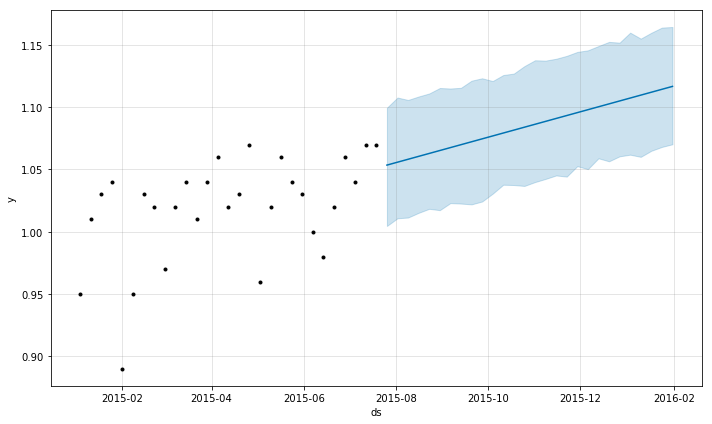

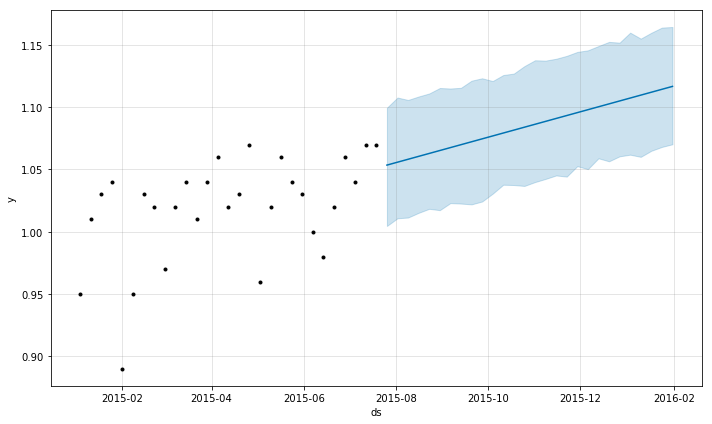

In [196]:
m.plot(predictions, uncertainty=True)

In [261]:
# For storing the model evaluation results
models = []
predictions = []
training_sets = []
testing_sets = []
fit_results = []
scores = []

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 22.0.
/Users/david/anaconda2/envs/PythonData/lib/python3.6/site-packages/fbprophet/forecaster.py:353: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  np.linspace(0, hist_size - 1, self.n_changepoints + 1)
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seas

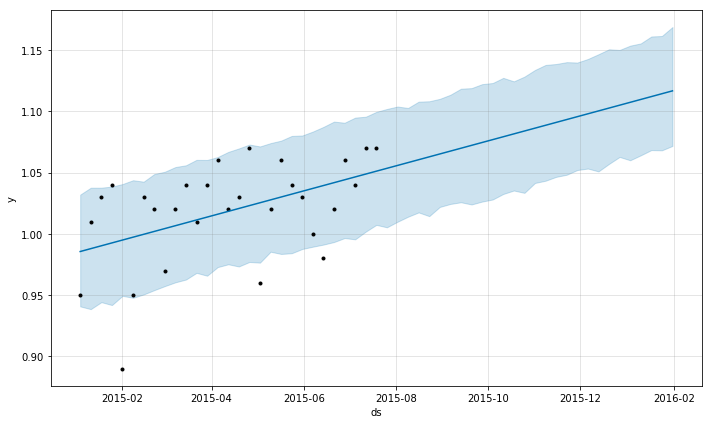

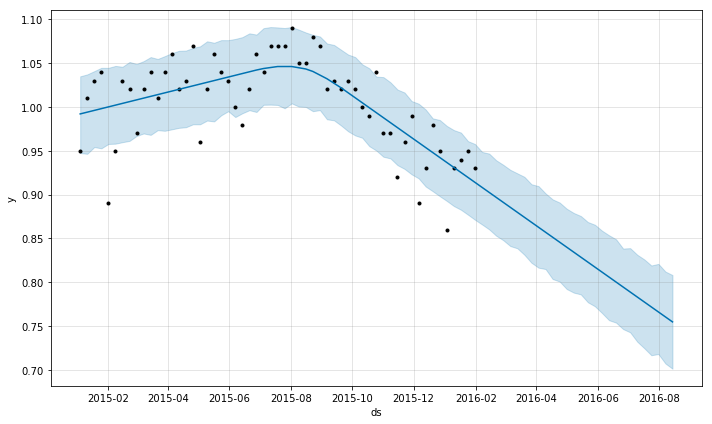

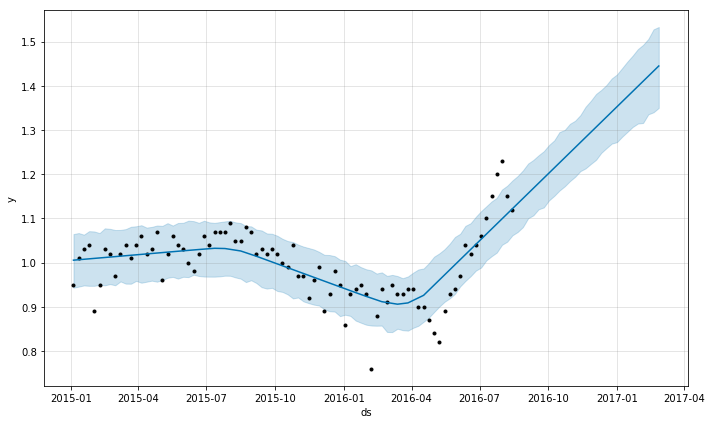

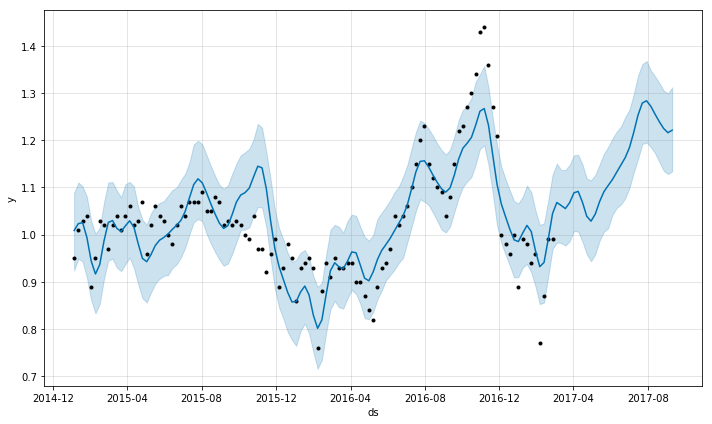

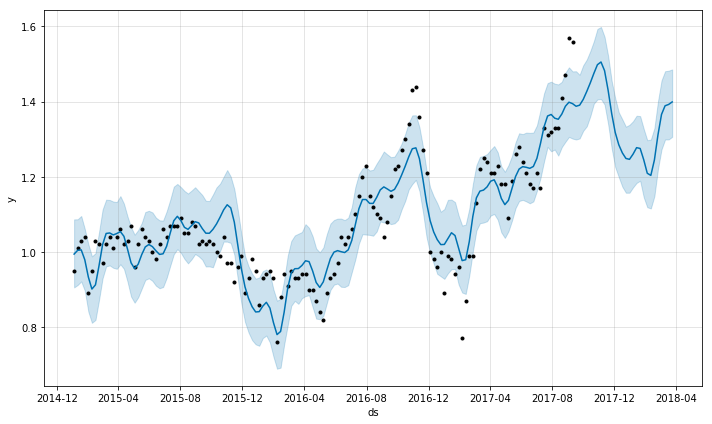

In [262]:
for train_tsi, test_tsi in tscv.split(time_series_groups):
    m = Prophet()
    df_train = df.iloc[train_tsi].copy()
    m.fit(df_train)
    df_test = df.iloc[test_tsi].copy()
    future = m.make_future_dataframe(len(test_tsi), freq='W', include_history=True)
    prediction = m.predict(future)
    
    test_subframe = prediction.iloc[test_tsi]
    train_subframe = prediction.iloc[train_tsi]
    rmse = math.sqrt(mean_squared_error(list(df_test['y']),list(test_subframe['yhat'])))
    error_percentage = rmse / np.average(list(df_test['y']))
    bias = mean_absolute_error(list(df_test['y']),list(test_subframe['yhat']))
    accuracy = bias / np.average(list(df_test['y']))
    scores.append( (rmse, error_percentage, bias, accuracy) )
    
    rmse = math.sqrt(mean_squared_error(list(df_train['y']),list(train_subframe['yhat'])))
    error_percentage = rmse / np.average(list(df_train['y']))
    bias = mean_absolute_error(list(df_train['y']),list(train_subframe['yhat']))
    accuracy = bias / np.average(list(df_train['y']))    

    fit_results.append( (rmse, error_percentage, bias, accuracy ) )
    
    models.append(m)
    predictions.append(prediction)
    
    m.plot(prediction, uncertainty=True)
    
    

## Random Forest with Numerical Data Only

In [ ]:
clf_rfn = make_pipeline(StandardScaler(), RandomForestRegressor(random_state=1, n_estimators=150))

In [ ]:
scores_rfn = cross_val_score(clf_rfn, Xtrain, ytrain, cv=3, n_jobs=-1)

In [ ]:
rfn_pipeline = clf_rfn.fit(Xtrain, ytrain)

In [ ]:
print("Random Forest with numerical data only: ")
print(f"{round(np.mean(scores_rfn),3)*100}% accuracy")
print(f"{mean_squared_error(y_pred=clf_rfn.predict(Xtest), y_true=ytest)} MSE")

## XGBoost Model with Numerical Data Only

In [ ]:
clf_xgboost = make_pipeline(StandardScaler(), XGBRegressor(n_estimators=1000, learning_rate=0.5, early_stopping_rounds=5))

In [ ]:
scores_xgb = cross_val_score(clf_xgboost, Xtrain, ytrain, cv=3, n_jobs=-1)

In [ ]:
xgb_pipeline = clf_xgboost.fit(Xtrain, ytrain)

In [ ]:
print("\nXGBoost Model with numerical data only:")
print(f"{round(np.mean(scores_xgb),3)*100}% accuracy")
print(f"{mean_squared_error(y_pred=clf_xgboost.predict(Xtest),y_true=ytest)} MSE")

## Random Forrest wth numerical + categorical data

In [ ]:
X_all = data_with_categorical.drop(columns='AveragePrice', axis=1).values
y_all = data_with_categorical['AveragePrice'].values.ravel()

In [ ]:
Xtrain_all, Xtest_all, ytrain_all, ytest_all = train_test_split(X_all, y_all, test_size=0.2, random_state=1)

In [ ]:
clf_rfa = make_pipeline(StandardScaler(), RandomForestRegressor(random_state=1, n_estimators=100))

In [ ]:
scores_rfa = cross_val_score(clf_rfa, Xtrain_all, ytrain_all, cv=3, n_jobs=-1)

In [ ]:
rfa_pipeline = clf_rfa.fit(Xtrain_all, ytrain_all)

In [ ]:
print("\nRandom Forrest with numerical and categorical data:")
print(f"{round(np.mean(scores_rfa),3)*100}% accuracy")
print(f"{mean_squared_error(y_pred=clf_rfa.predict(Xtest_all), y_true=ytest_all)} MSE")